In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [62]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [64]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [66]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, activation_fn):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.activation = activation_fn
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)  # No activation for output layer (CrossEntropyLoss includes Softmax)
        return x

In [68]:
# Activation functions
activation_functions = {
    "Sigmoid": nn.Sigmoid(),
    "Tanh": nn.Tanh(),
    "ReLU": nn.ReLU(),
    "Leaky ReLU": nn.LeakyReLU(0.01),
    "Swish": lambda x: x * torch.sigmoid(x)
}

In [70]:
# Train and evaluate function
def train_and_evaluate(activation_name, activation_fn, epochs=5):
    model = MLP(activation_fn).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_acc, test_acc = [], []
    train_loss = []  # Track training loss for plotting

    for epoch in range(epochs):
        correct, total, running_loss = 0, 0, 0.0
        model.train()
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        train_acc.append(100 * correct / total)
        train_loss.append(running_loss / len(trainloader))  # Append the average loss for the epoch 
        # Evaluate on test set
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        test_acc.append(100 * correct / total)
        
        print(f"{activation_name} - Epoch {epoch+1}/{epochs} - Train Accuracy: {train_acc[-1]:.2f}% - Test Accuracy: {test_acc[-1]:.2f}%")
    
    return train_acc, test_acc, train_loss

In [72]:
# Train models with different activation functions
results = {}
for name, activation in activation_functions.items():
    print(f"\nTraining with {name} activation...\n")
    results[name] = train_and_evaluate(name, activation)


Training with Sigmoid activation...

Sigmoid - Epoch 1/5 - Train Accuracy: 83.70% - Test Accuracy: 92.78%
Sigmoid - Epoch 2/5 - Train Accuracy: 93.73% - Test Accuracy: 94.86%
Sigmoid - Epoch 3/5 - Train Accuracy: 95.48% - Test Accuracy: 95.27%
Sigmoid - Epoch 4/5 - Train Accuracy: 96.50% - Test Accuracy: 96.13%
Sigmoid - Epoch 5/5 - Train Accuracy: 97.10% - Test Accuracy: 96.48%

Training with Tanh activation...

Tanh - Epoch 1/5 - Train Accuracy: 90.38% - Test Accuracy: 94.70%
Tanh - Epoch 2/5 - Train Accuracy: 95.09% - Test Accuracy: 95.98%
Tanh - Epoch 3/5 - Train Accuracy: 95.92% - Test Accuracy: 95.50%
Tanh - Epoch 4/5 - Train Accuracy: 96.47% - Test Accuracy: 95.76%
Tanh - Epoch 5/5 - Train Accuracy: 96.53% - Test Accuracy: 96.32%

Training with ReLU activation...

ReLU - Epoch 1/5 - Train Accuracy: 88.29% - Test Accuracy: 93.65%
ReLU - Epoch 2/5 - Train Accuracy: 94.30% - Test Accuracy: 95.40%
ReLU - Epoch 3/5 - Train Accuracy: 95.84% - Test Accuracy: 96.45%
ReLU - Epoch 4/5 - 

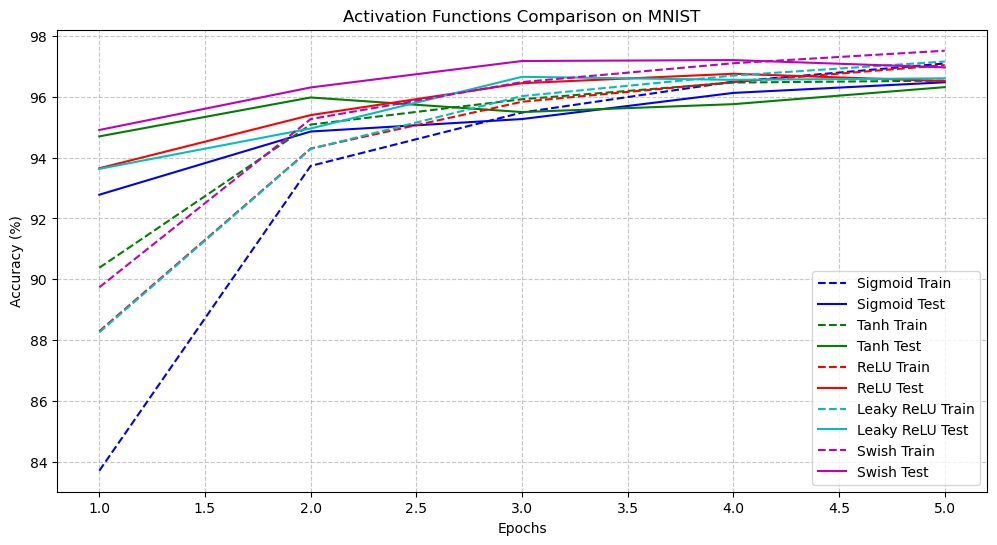

In [74]:
# Plot results for accuracy comparison
plt.figure(figsize=(12, 6))
colors = ['b', 'g', 'r', 'c', 'm']

for i, (name, (train_acc, test_acc, _)) in enumerate(results.items()):
    plt.plot(range(1, 6), train_acc, label=f"{name} Train", linestyle='dashed', color=colors[i])
    plt.plot(range(1, 6), test_acc, label=f"{name} Test", linestyle='solid', color=colors[i])

plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Activation Functions Comparison on MNIST")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

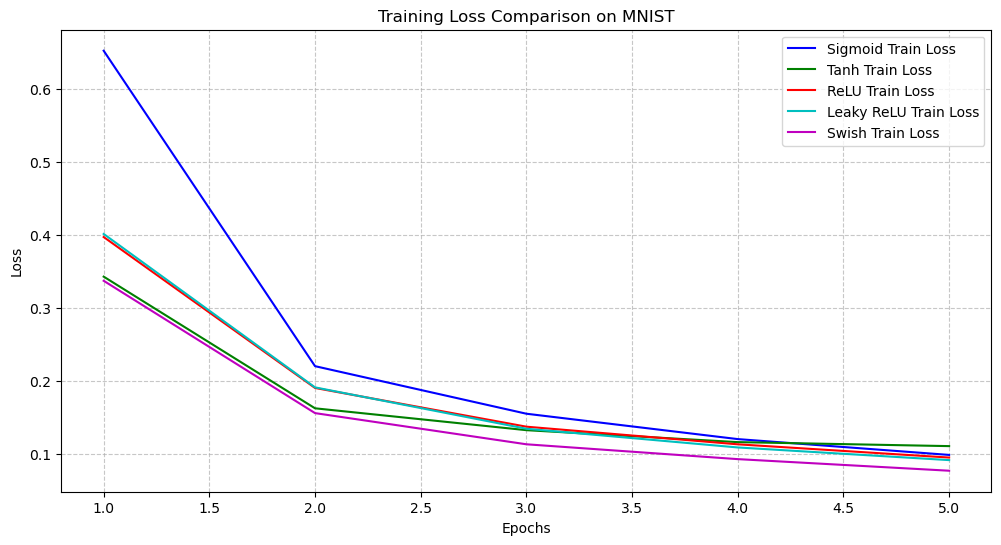

In [76]:
# Plot results for training loss comparison
plt.figure(figsize=(12, 6))
for i, (name, (_, _, train_loss)) in enumerate(results.items()):
    plt.plot(range(1, 6), train_loss, label=f"{name} Train Loss", color=colors[i])

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Comparison on MNIST")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()